# Set up environment

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import os
import sys
import PIL.Image as Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import sqlite3
import xml.etree.cElementTree as ET

## Import utility functions from Pytorch

In [2]:
ROOT_DIR = os.path.dirname(os.path.dirname(os.getcwd()))

sys.path.append(os.path.join(ROOT_DIR, "utilities"))

from engine import evaluate

## Declare parameters

In [3]:
FOOD256_DIR = os.path.join(os.path.abspath(os.sep), "Datasets", "food256")

IMAGE_SIZE = 512
BATCH_SIZE = 1

## Enable GPU

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on", device)

Running on cuda:0


# Input testing data

## Define FoodDataset class

In [5]:
class FoodDataset(torch.utils.data.Dataset):
    def __init__(self, root, images, transform=None):
        self.root = root
        self.transform = transform
        self.images = images
        self.classes = self.getClasses()
                
                
    def getClasses(self):
        classes = []
        with open(os.path.join(self.root, "category.txt"), 'r') as file:
            file.readline()
            for line in file.readlines():
                classes.append(line.strip().split("\t")[1])
        return classes
    
    
    def getLabels(self, img_id):
        # open annotations file
        tree = ET.parse(os.path.join(self.root, "Annotations", img_id+'.xml'))
        root = tree.getroot()
        
        boxes = []
        areas = []
        labels = []
    
        # read bounding boxes
        for obj in root.findall('object'):
            class_name = obj.find('name').text

            # get bounding box
            box = obj.find('bndbox')
            x1 = float(box.find('xmin').text)
            y1 = float(box.find('ymin').text)
            x2 = float(box.find('xmax').text)
            y2 = float(box.find('ymax').text)

            boxes.append([x1, y1, x2, y2])
            areas.append((x2-x1)*(y2-y1))
            labels.append(self.classes.index(class_name))
        
        return boxes, areas, labels

        
    def __getitem__(self, index):
        # image
        img_path = os.path.join(self.root, "JPEGImages", self.images[index])
        img = Image.open(img_path).convert("RGB")
        
        # annotations
        boxes, areas, labels = self.getLabels(self.images[index].split('.')[0])

        target = {
            "image_id": torch.tensor([index]),
            "labels": torch.as_tensor(labels, dtype=torch.int64),
            "boxes": torch.as_tensor(boxes, dtype=torch.float32),
            "area": torch.as_tensor(areas),
            "iscrowd": torch.zeros((len(labels),), dtype=torch.int64)
        }
        
        if self.transform is not None:
            img, target = self.transform(img, target)
            
        return img, target
        
    
    def __len__(self):
        return len(self.images)

## Format images for model input

In [6]:
# custom transform for R-CNN input
class CustomTransform:
    def __init__(self, image_size):
        self.image_size = image_size
        
    def __call__(self, img, target):
        # resize to a max of IMAGE_SIZE
        w, h = img.size
        scale = min(IMAGE_SIZE/w, IMAGE_SIZE/h)
        img = transforms.functional.resize(img, (int(h*scale), int(w*scale)))
        
        # update bounding boxes
        target["boxes"] *= scale
        
        # update areas
        target["area"] *= scale**2
        
        # add padding to a size of IMAGE_SIZE
        img = transforms.functional.pad(img, (0, 0, IMAGE_SIZE-int(w*scale), IMAGE_SIZE-int(h*scale)))
        
        # convert to tensor
        img = transforms.functional.to_tensor(img)

        # normalize
        img = transforms.functional.normalize(img, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        
        return img, target

transform = CustomTransform(image_size=IMAGE_SIZE)

## Read testing split

In [7]:
SPLIT_DIR = os.path.join(FOOD256_DIR, "ImageSets", "Main")

with open(os.path.join(SPLIT_DIR, "val.txt"), 'r') as file:
    images = [x.strip() for x in file.readlines()]
    val_raw = FoodDataset(FOOD256_DIR, images, transform=transform)
    

val_size = len(val_raw)

class_names = val_raw.classes

print("Number of validation images: {0}".format(val_size))

# define how to batch data (i.e not combine target dicitonaries)
def collate_fn(batch):
    return tuple(zip(*batch))

val_loader = torch.utils.data.DataLoader(val_raw, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

Number of validation images: 2890


## Show example testing image with bounding boxes

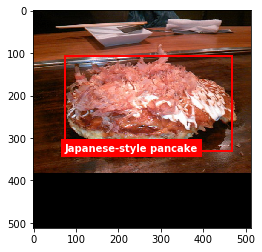

In [8]:
fig, axis= plt.subplots(1)

#randomly select image from dataset
i = np.random.randint(val_size)
img = val_raw[i][0].clone().numpy()

# unnormalize
img[0] = img[0] * 0.229
img[1] = img[1] * 0.224 
img[2] = img[2] * 0.225 
img[0] += 0.485 
img[1] += 0.456 
img[2] += 0.406
    
img = np.transpose(img, (1,2,0))
img = np.clip(img, 0, 1)
plt.imshow(img)

labels = val_raw[i][1]["labels"]
boxes = val_raw[i][1]["boxes"]

# draw bounding boxes
for i in range(len(labels)):
    x1, y1, x2, y2 = boxes[i]
    box = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='r', facecolor='none')
    axis.add_patch(box)
    axis.text(x1, y2, class_names[labels[i]], fontdict=dict(color='w', weight='bold'), bbox=dict(facecolor='r', edgecolor='none'))
    
fig

# Model

## Declare model architecture

Currently supports:
    - resnet_50
    - mobilenet_v2

In [13]:
MODEL_NAME = "resnet_50"

## Fetch model architecture

In [14]:
print("Fetching model architecture... ", end="")

if MODEL_NAME == "resnet_50":
    # fetch pretrained faster RCNN model with default resnet-50 backbone
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
    
    # replace classification head
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, len(class_names)+1)
    
    
elif MODEL_NAME == "mobilenet_v2":
    # fetch backbone model architecture
    backbone = torchvision.models.mobilenet_v2(pretrained=False)
    
    # replace classification head
    num_features = backbone.classifier[1].in_features
    backbone.classifier[1] = torch.nn.Linear(num_features, len(class_names))

    # remove classification head
    backbone = backbone.features
    backbone.out_channels = 1280
    
    # encapsulate backbone within faster RCNN model
    anchor_generator = torchvision.models.detection.rpn.AnchorGenerator(sizes=((32, 64, 128, 256, 512),), aspect_ratios=((0.5, 1.0, 2.0),))
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'], output_size=7, sampling_ratio=2)
    model = torchvision.models.detection.FasterRCNN(backbone, num_classes=len(class_names), rpn_anchor_generator=anchor_generator, box_roi_pool=roi_pooler)


model = model.to(device)

print("done")

Fetching model architecture... done


## Load model weights

In [15]:
MODEL_PATH = os.path.join(ROOT_DIR, "models", "food_detection", MODEL_NAME, "fine_tuning.pt")

print("Loading learnt model weights...", end="")
model.load_state_dict(torch.load(MODEL_PATH))
print("done")

Loading learnt model weights...done


# Evaluate model on testing dataset

In [16]:
evaluate(model, val_loader, device)

creating index...
index created!
Test:  [   0/2890]  eta: 0:07:22  model_time: 0.1191 (0.1191)  evaluator_time: 0.0040 (0.0040)  time: 0.1530  data: 0.0100  max mem: 641
Test:  [ 100/2890]  eta: 0:04:28  model_time: 0.0848 (0.0820)  evaluator_time: 0.0030 (0.0035)  time: 0.0990  data: 0.0094  max mem: 641
Test:  [ 200/2890]  eta: 0:04:26  model_time: 0.0856 (0.0837)  evaluator_time: 0.0040 (0.0042)  time: 0.1008  data: 0.0099  max mem: 641
Test:  [ 300/2890]  eta: 0:04:18  model_time: 0.0908 (0.0849)  evaluator_time: 0.0030 (0.0040)  time: 0.1055  data: 0.0098  max mem: 641
Test:  [ 400/2890]  eta: 0:04:12  model_time: 0.0901 (0.0864)  evaluator_time: 0.0030 (0.0039)  time: 0.1051  data: 0.0100  max mem: 641
Test:  [ 500/2890]  eta: 0:04:03  model_time: 0.0893 (0.0870)  evaluator_time: 0.0030 (0.0038)  time: 0.1049  data: 0.0101  max mem: 641
Test:  [ 600/2890]  eta: 0:03:55  model_time: 0.0908 (0.0876)  evaluator_time: 0.0040 (0.0038)  time: 0.1062  data: 0.0098  max mem: 641
Test:  [